In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import torch
import random

2024-03-02 23:54:37.397160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation
    
model = Sequential()
model.add(Dense(128, input_dim=2, activation = 'sigmoid'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='sgd',
                 loss='categorical_crossentropy',
             metrics=['accuracy'])

## Data Generation

In [17]:
max_moves = 10  #how many inverse operations on the final destination
goal_position = torch.tensor([[1], [0]], dtype=torch.float64) #start with a 2 x 1 

def data_generator(matrix_T, matrix_U, num_of_datapoints):
    inverse_T = torch.inverse(matrix_T)
    inverse_U = torch.inverse(matrix_U)
    data = torch.empty((num_of_datapoints, 3), dtype=torch.int32)
    for i in range(num_of_datapoints):
        start = goal_position
        moves = random.randint(1, max_moves)
        coin = random.randint(0, 3)
        prev_coin = -1
        for q in range(moves):
            if coin == 0:
                #  print(start, inverse_U, "=")
                start = torch.matmul(matrix_T, start)
                prev_coin = coin
                coin = random.randint(0, 3)
                while coin == 2: 
                    coin = random.randint(0, 3)
            #  print(start)
            if coin == 1:
                #  print(start, inverse_T, "=")
                start = torch.matmul(matrix_U, start)
                prev_coin = coin
                coin = random.randint(0, 3)
                while coin == 3: 
                    coin = random.randint(0, 3)
            if coin == 2:
                #  print(start, inverse_U, "=")
                start = torch.matmul(inverse_T, start)
                prev_coin = coin
                coin = random.randint(0, 3)
                while coin == 0: 
                    coin = random.randint(0, 3)
            #  print(start)
            else:
                #  print(start, inverse_T, "=")
                start = torch.matmul(inverse_U, start)
                prev_coin = coin
                coin = random.randint(0, 3)
                while coin == 1: 
                    coin = random.randint(0, 3)
            # print(start)
        # print("done")
        data[i, 0] = start[0]
        data[i, 1] = start[1]
        data[i, 2] = prev_coin
    return data

#https://stackoverflow.com/questions/36158058/torch-save-tensor-to-csv-file#:~:text=For%20simple%20tables%2C%20you%20can,then%20to%20a%20Pandas%20dataframe.&text=You%20can%20first%20convert%20the,table%20as%20a%20csv%20file.

matrix_T = torch.tensor([[1, 3], [0, 1]], dtype=torch.float64)
matrix_U = torch.tensor([[1, 0], [3, 1]], dtype=torch.float64)

data = data_generator(matrix_T, matrix_U, 10000)
data_table = data.numpy()

x_train = data_table[:, :-1]
y_train_number = data_table[:, -1]

# matrix_T = torch.tensor([[0, -1], [1, 0]], dtype=torch.float64)
# matrix_U = torch.tensor([[1, 1], [0, 1]], dtype=torch.float64)

data = data_generator(matrix_T, matrix_U, 10000)
data_table = data.numpy()

x_test = data_table[:, :-1]
y_test_number = data_table[:, -1]

## Helper Functions

In [4]:
# One hot encoding 
# some parts from chat GPT 
y_train = []

def one_hot_encode(number):
    if number < 0 or number > 3:
        raise ValueError("Number must be between 0 and 3.")
    
    encoding = np.zeros((1, 4))  # Initialize the encoding vector with all zeros
    encoding[0][number] = 1    # Set the value at the index corresponding to the number to 1
    return encoding

for i in range(len(y_train_number)):
    y_train.append(one_hot_encode(y_train_number[i]))

# Convert the list to a NumPy array
y_train = np.array(y_train)
y_train = y_train.reshape((len(y_train_number), 4))

y_test = []

def one_hot_encode(number):
    if number < 0 or number > 3:
        raise ValueError("Number must be between 0 and 3.")
    
    encoding = np.zeros((1, 4))  # Initialize the encoding vector with all zeros
    encoding[0][number] = 1    # Set the value at the index corresponding to the number to 1
    return encoding

for i in range(len(y_test_number)):
    y_test.append(one_hot_encode(y_test_number[i]))

# Convert the list to a NumPy array
y_test = np.array(y_test)
y_test = y_test.reshape((len(y_test_number), 4))

In [5]:
def lr_schedule(epoch, lr: float) -> float:
    if epoch == 25:
        return lr * .75
    if epoch == 50:
        return lr * .75
    if epoch == 75:
        return lr * .75
    return lr

## Model Definition

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Activation

#
model = Sequential()
model.add(Dense(128, input_dim=2, activation = 'sigmoid'))
model.add(Dense(64,  activation = 'sigmoid'))
model.add(Dense(16, activation = 'sigmoid'))
model.add(Dense(4, activation = 'softmax'))

# From GPT to save the best performing weights
model_checkpoint_callback = ModelCheckpoint(
    filepath='checkpoint_model.h5',  # Path where to save the model
    save_best_only=True,               # Only save a model if `val_loss` has improved
    monitor='loss',                # Monitor validation loss for improvement
    mode='min',                        # The lower the `val_loss`, the better
    verbose=1)

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Training And Output

In [7]:
model.fit(x_train, y_train, epochs=100, batch_size=100, callbacks=[lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.003000000026077032.
Epoch 1/100
100/100 [==============================] - 2s 2ms/step - loss: 1.0742 - accuracy: 0.5835 - lr: 0.0030

Epoch 2: LearningRateScheduler setting learning rate to 0.003000000026077032.
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 0.8374 - accuracy: 0.6929 - lr: 0.0030

Epoch 3: LearningRateScheduler setting learning rate to 0.003000000026077032.
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 0.7950 - accuracy: 0.6977 - lr: 0.0030

Epoch 4: LearningRateScheduler setting learning rate to 0.003000000026077032.
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.7824 - accuracy: 0.7010 - lr: 0.0030

Epoch 5: LearningRateScheduler setting learning rate to 0.003000000026077032.
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.7734 - accuracy: 0.7019 - lr: 0.0030

Epoch 6: LearningRateScheduler set

In [8]:
score = model.evaluate(x_test, y_test, batch_size=100)
print(score[0])
print(score[1])

100/100 [==============================] - 0s 2ms/step - loss: 0.7093 - accuracy: 0.7125
0.7093222141265869
0.7124999761581421


In [9]:
model.save('full_model.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


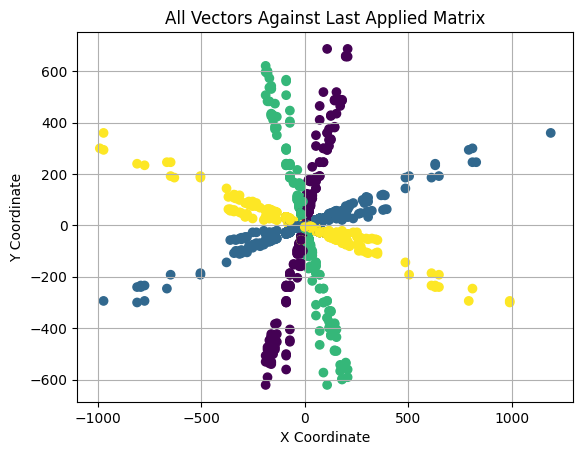

In [10]:
# Non-random datagen Essential the space of all vectors that are possible from using the above 
# defined SL2Z generators
nrdata = []
b = torch.tensor([[1,3], [0,1]], dtype=torch.float64)
c = torch.tensor([[1,0], [3,1]], dtype=torch.float64)
binv = torch.inverse(b)
cinv = torch.inverse(c)

queue = [torch.tensor([[1],[0]], dtype=torch.float64).T]
for i in range(1000):
    item = queue.pop(0)

    item_prime = [torch.matmul(item, b), 0]
    queue.append(item_prime[0])
    nrdata.append(item_prime)

    item_prime = [torch.matmul(item, c), 1]
    queue.append(item_prime[0])
    nrdata.append(item_prime)

    item_prime = [torch.matmul(item, binv), 2]
    queue.append(item_prime[0])
    nrdata.append(item_prime)

    item_prime = [torch.matmul(item, cinv), 3]
    queue.append(item_prime[0])
    nrdata.append(item_prime)

ts, d = zip(*nrdata)
x = list(el[0,0] for el in ts)
y = list(el[0,1] for el in ts)

plt.scatter(x, y, c=d)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('All Vectors Against Last Applied Matrix')
plt.grid(True)
plt.show()

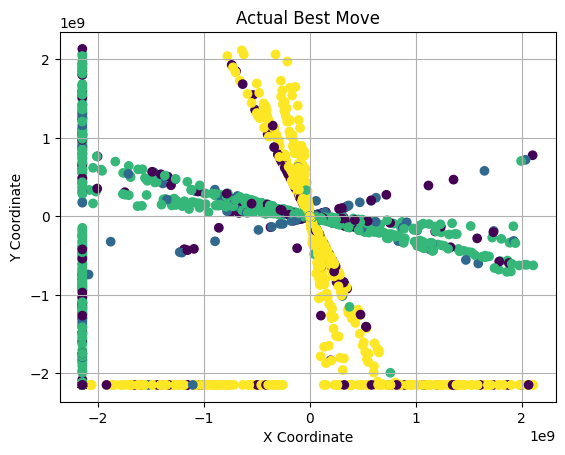

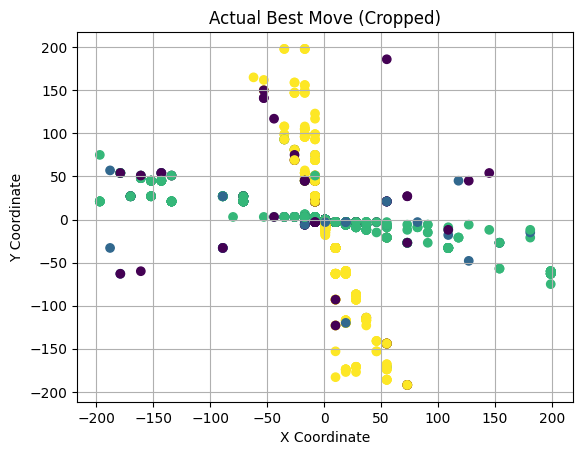

In [11]:
# Visualization of training data acheived from random walks within the above space
x = data[:, 0]
y = data[:, 1]
d = data[:, 2]

plt.scatter(x, y, c=d)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual Best Move')
plt.grid(True)
plt.show()

mask1 = x < 200
mask2 = x > -200
mask3 = y < 200
mask4 = y > -200
mask = mask1 & mask2 & mask3 & mask4

x = x[mask]
y = y[mask]
d = d[mask]

plt.scatter(x, y, c=d)
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Actual Best Move (Cropped)')
plt.grid(True)
plt.show()


## Learned Descision Boundary

1/1 [==============================] - 0s 128ms/step


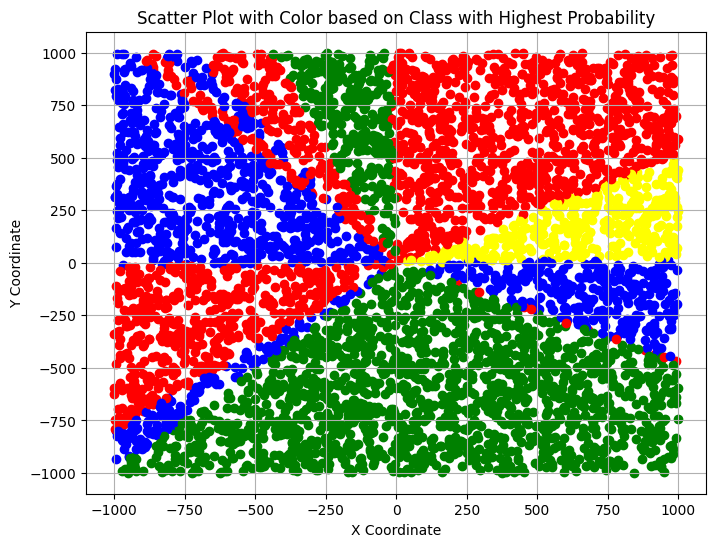

In [12]:
import numpy as np
import matplotlib.pyplot as plt

x = random.randint(-1000, 1000)
y = random.randint(-1000, 1000)

# Example model output with shape (100, 4)
model_output = model.predict(torch.tensor([[x, y]]).numpy())  # Example model output with shape (100, 4)


# Scatter plot
plt.figure(figsize=(8, 6))

# Iterate over the loop to generate coordinates one at a time
for i in range(5000):
    # Generate x and y coordinates one at a time
    x = random.randint(-1000, 1000)
    y = random.randint(-1000, 1000)

# Example model output with shape (100, 4)
    #print(x, y)
    model_output = model.predict(torch.tensor([[x, y]]).numpy(), verbose=0)  # Example model output with shape (100, 4)
    
    # Find the index of the maximum probability for this point
    max_prob_index = np.argmax(model_output)
    #print(model_output, max_prob_index)
    
    # Plot the point with color based on the class with highest probability
    col = 'blue'
    if (max_prob_index == 0):
        col = 'red'
    elif (max_prob_index == 1):
        col = 'yellow'
    elif (max_prob_index == 2):
        col = 'blue'
    elif (max_prob_index == 3):
        col = 'green'
    plt.scatter(x, y, c=col)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Scatter Plot with Color based on Class with Highest Probability')
plt.grid(True)
plt.show()


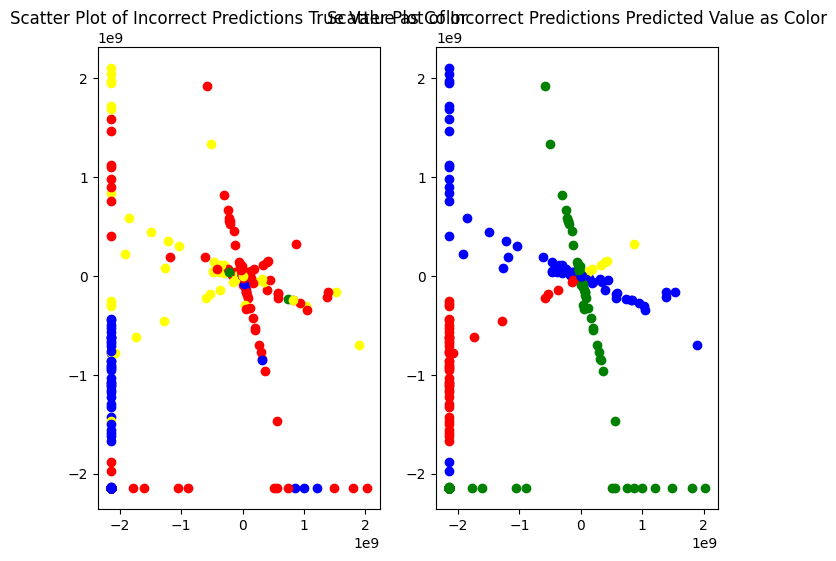

In [14]:
matrix_T = torch.tensor([[1, 3], [0, 1]], dtype=torch.float64)
matrix_U = torch.tensor([[1, 0], [3, 1]], dtype=torch.float64)

example_points = data_generator(matrix_T, matrix_U, 5000)

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


for i in range(len(example_points)): 
    x = example_points[i][0]
    y = example_points[i][1]
    model_output = model.predict(torch.tensor([[x, y]]).numpy(), verbose=0)  # Example model output with shape (100, 4)
    
    # Find the index of the maximum probability for this point
    max_prob_index = np.argmax(model_output)
    #print(model_output, max_prob_index)
    
    # Plot the point with color based on the class with highest probability
    col_one = 'purple'
    if (max_prob_index != example_points[i][2]):
        if (example_points[i][2] == 0):
            col_one = 'red'
        elif (example_points[i][2] == 1):
            col_one = 'yellow'
        elif (example_points[i][2] == 2):
            col_one = 'blue'
        elif (example_points[i][2] == 3):
            col_one = 'green'
    col_two = 'purple'
    if (max_prob_index != example_points[i][2]):
        if (max_prob_index == 0):
            col_two = 'red'
        elif (max_prob_index == 1):
            col_two = 'yellow'
        elif (max_prob_index == 2):
            col_two = 'blue'
        elif (max_prob_index == 3):
            col_two = 'green'

    if (col_one != 'purple'):
        ax1.scatter(x, y, c=col_one)
        ax1.set_title('Scatter Plot of Incorrect Predictions True Value as Color')
        ax2.scatter(x,y, c=col_two)
        ax2.set_title('Scatter Plot of Incorrect Predictions Predicted Value as Color')

# from https://chris35wills.github.io/courses/PythonPackages_matplotlib/matplotlib_multiple_figs/




In [28]:

# FOLLOW IT THROUGH

# matrix_T = torch.tensor([[0, -1], [1, 0]], dtype=torch.float64)
# matrix_U = torch.tensor([[1, 1], [0, 1]], dtype=torch.float64)
matrix_T = torch.tensor([[1, 3], [0, 1]], dtype=torch.float64)
matrix_U = torch.tensor([[1, 0], [3, 1]], dtype=torch.float64)
inverse_matrix_T = torch.inverse(matrix_T)
inverse_matrix_U = torch.inverse(matrix_U)

array = data_generator(matrix_T, matrix_U, 1).numpy()[:, :-1]

matrix = array.reshape(1, 2)
iterations = 0

print(array)
print(matrix)

def is_target_array(array):
    target = np.array([1, 0])
    return np.array_equal(array, target)

while not (array[0][0] == 1 and array[0][1] == 0) and iterations <= 20:
    model_output = model.predict(array)  
    
    # Find the index of the maximum probability for this point
    max_prob_index = np.argmax(model_output)
    iterations = iterations + 1
    if max_prob_index == 0: 
        matrix = matrix @ inverse_matrix_T.numpy()
        print("APPLIED invT")
    elif max_prob_index == 1: 
        matrix = matrix @ inverse_matrix_U.numpy()
        print("APPLIED invU")
    elif max_prob_index == 2: 
        matrix = matrix @ matrix_T.numpy()
        print("APPLIED T")
    else: 
        matrix = matrix @ matrix_U.numpy()
        print("APPLIED U")
    array = matrix.reshape(1,2)
    print(iterations)

print(array)
print(matrix)

[[-17  45]]
[[-17  45]]
1/1 [==============================] - 0s 29ms/step
APPLIED U
1
1/1 [==============================] - 0s 30ms/step
APPLIED invT
2
1/1 [==============================] - 0s 29ms/step
APPLIED U
3
1/1 [==============================] - 0s 33ms/step
APPLIED invT
4
1/1 [==============================] - 0s 30ms/step
APPLIED U
5
1/1 [==============================] - 0s 31ms/step
APPLIED invU
6
1/1 [==============================] - 0s 30ms/step
APPLIED U
7
1/1 [==============================] - 0s 30ms/step
APPLIED invU
8
1/1 [==============================] - 0s 31ms/step
APPLIED U
9
1/1 [==============================] - 0s 31ms/step
APPLIED invU
10
1/1 [==============================] - 0s 31ms/step
APPLIED U
11
1/1 [==============================] - 0s 30ms/step
APPLIED invU
12
1/1 [==============================] - 0s 29ms/step
APPLIED U
13
1/1 [==============================] - 0s 31ms/step
APPLIED invU
14
1/1 [==============================] - 0s 30ms/step
AP